In [48]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import os
import time
import torch
from torch.autograd import Variable

import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image
import pickle



### Methods

In [17]:
sample_batch = "nsample_1107"
sample_dir = "CHIMES_0.6/Out/{}/{}_csv".format(sample_batch,sample_batch)
CLIPPING = [1e-35,1]

def get_all_ab(df,norm=True):
    
    x = []
    y = []
    
    densh = np.mean(df["nh"].values)
    print(df.columns)
    # REMOVE LATER (cols already selected)
    cols = df.columns[4:-21]
    #print(cols)
    nspec = len(cols)
    select_times = df["t(Myrs)"].unique()[10:-10]
    for t in select_times:
        xx = np.zeros(nspec)
        yy = np.zeros(2*nspec)
        grph =df[np.logical_and(df["t(Myrs)"]==t,df["datatype"]=="graph")][cols].iloc[0]
        drv =  df[np.logical_and(df["t(Myrs)"]==t,df["datatype"]=="deriv")][cols].iloc[0]
        
        xx[:] = grph.values[:]
        if(norm):
            xx = xx/densh
       # print(xx,np.max(xx),np.mean(xx),np.std(xx))
        yy[:nspec] = xx[:]
        yy[nspec:] = drv.values[:]
        
        x.append(xx)
        y.append(yy)
    return list(cols),select_times,x,y

def get_vecs(df,N,use_all=False,chose="equal",norm=True):
    
    x = []
    y = []
    
    
    #print(df.columns)
    # REMOVE LATER (cols already selected)
    densh = np.mean(df["nh"].values)
    #print(densh)
    cols = df.columns[4:-21]
   # print(cols)
    nspec = len(cols)
    select_times = df["t(Myrs)"].unique()[10:-10]#appears t be a prblem with the last 10 lines (many ab 1e-16)
    
    if(not use_all):
        if chose=="equal":
            #nget = int(len(df)/N)
            #logt = [np.log10(x) for x in select_times ]
            timelogspace = np.linspace(np.log10(select_times[0]),np.log10(select_times[-1]),N)
            select_times = [min(select_times, key=lambda x:abs(x-10**t)) for t in timelogspace]
            
            
            #idxx  = np.round(np.logspace(0,np.log10(len(select_times)-1),N)) 
            #select_times=[select_times[int(j)] for j in idxx]
            #selected_times = select_times[::nget]
        elif chose=="random":
            select_times = np.random.choice(select_times,N)
    
    for t in select_times:
        xx = np.zeros(nspec)
        yy = np.zeros(2*nspec)
        grph =df[np.logical_and(df["t(Myrs)"]==t,df["datatype"]=="graph")][cols].iloc[0]
        drv =  df[np.logical_and(df["t(Myrs)"]==t,df["datatype"]=="deriv")][cols].iloc[0]
        
        xx[:] = grph.values[:]
        if(norm):
            xx = xx/densh
       # print(xx,np.max(xx),np.mean(xx),np.std(xx))
        yy[:nspec] = xx[:]
        yy[nspec:] = drv.values[:]
        
        x.append(xx)
        y.append(yy)
    return list(cols),select_times,x,y
    

def create_dataset(dirpath,N_per_model,dataset_type="train_test",test_size=0.3,val_size=0.3,choice="random",max_batch=None,savename = None):
    
    dirfiles = [f for f in os.listdir(dirpath)if f.endswith(".csv.gz")]
    if max_batch:
        dirfiles= dirfiles[:min(max_batch,len(dirfiles))]
        print(dirfiles)
        
    if(dataset_type == "train_test"):
        X = []
        Y = []


        total_s =  len(dirfiles)*N_per_model
        print("{} lines for each of the {} models = {} samples".format(N_per_model,len(dirfiles),total_s))
        print("  {} samples for training".format(int(total_s*(1-test_size)*(1-val_size))))
        print("  {} samples for validating".format(int(total_s*(1-test_size)*val_size)))
        print("  {} samples for testing".format(int(total_s*test_size)))
        for i in range(len(dirfiles)):
            filename = dirfiles[i]

            s = "extracting {0} ... ".format(filename)
            if i == len(dirfiles)-1:
                s+='\n'        
            if i>0:
                s = '\r'+s
            print(s, end='')

            filepath = os.path.join(dirpath, filename)
            data = pd.read_csv(filepath,compression="gzip")
            cols_,sel_t,x,y = get_vecs(data,N_per_model,chose=choice)
            for i in range(len(x)):
                X.append(x[i])
                Y.append(y[i])


        print("Extraction completed. Splitting dataset...")
        X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=test_size)
        X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=val_size)
        print ("Done.")
        pack = {"cols":cols_,"times":sel_t,"x_train":X_train,"x_val":X_val,"x_test":X_test,"y_train":y_train,"y_val":y_val,"y_test":y_test}
        if(savename):
            np.savez_compressed(savename,cols=cols_,times=sel_t,x_train=X_train,x_test=X_test,x_val=X_val,y_train=y_train,y_test=y_test,y_val=y_val)
        return pack
    
    
    elif(dataset_type=="all_model"):
        
        models = {}

        total_s =  len(dirfiles)
        print(" {} samples".format(total_s))

        for i in range(len(dirfiles)):
            filename = dirfiles[i]

            s = "extracting {0} ... ".format(filename)
            if i == len(dirfiles)-1:
                s+='\n'        
            if i>0:
                s = '\r'+s
            print(s, end='')

            filepath = os.path.join(dirpath, filename)
            data = pd.read_csv(filepath,compression="gzip")
            cols_,sel_t,x,y = get_vecs(data,N_per_model,use_all=True)
            
            models["sc_"+str(i+1)] = {"x":x,"t":sel_t}
        models["cols"]=cols_


        print("Extraction completed.")
        #pack = {"cols":cols_,"times":sel_t,"x_train":X_train,"x_val":X_val,"x_test":X_test,"y_train":y_train,"y_val":y_val,"y_test":y_test}
        if(savename):
            np.save(savename,models)
        return models
        

def retrieve_dataset(filepath):
    data = np.load(filepath,allow_pickle=True)
    return data


def log_mse_loss(output, target):
    
    #log_o = torch.log10(torch.clamp(output,min=eps,max=1))
    #log_t = torch.log10(torch.clamp(target,min=eps,max=1))
    #loss = torch.mean((log_o - log_t)**2)
    loss = torch.mean((output - target)**2)
    return loss


def RMSE(output,target,mean=True):
    output = reconstruct_output(output,CLIPPING[0],CLIPPING[1])
    target = reconstruct_output(target,CLIPPING[0],CLIPPING[1])
    
    loss = (np.log10(output)-np.log10(target))**2
    
    ans = np.sqrt(np.mean(loss)) if mean else np.sqrt(loss) 
    return ans
    

def loss_per_species(output,target):
    loss = (output - target)**2
    loss = loss.detach().apply_(lambda x: x/1)
    return loss.numpy()

def RMSE(output,target):
    output = reconstruct_output(output,CLIPPING[0],CLIPPING[1])
    target = reconstruct_output(target,CLIPPING[0],CLIPPING[1])
    
    loss = (np.log10(output)-np.log10(target))**2
    
    return np.sqrt(np.mean(loss))
    

#### Network architecture

In [3]:
## CUSTOM LAYER
class MyLinearLayer(nn.Module):
    """ Custom Linear layer but mimics a standard linear layer """
    def __init__(self, size_in):
        super().__init__()
        self.size_in, self.size_out = size_in, size_out
        weights = torch.Tensor(size_out, size_in)
        self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.
        bias = torch.Tensor(size_out)
        self.bias = nn.Parameter(bias)

        # initialize weights and biases
        nn.init.kaiming_uniform_(self.weights, a=math.sqrt(5)) # weight init
        fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weights)
        bound = 1 / math.sqrt(fan_in)
        nn.init.uniform_(self.bias, -bound, bound)  # bias init

    def forward(self, x):
        w_times_x= torch.mm(x, self.weights.t())
        return torch.add(w_times_x, self.bias)  # w times x + b

In [4]:
class autoencoder(nn.Module):
    def __init__(self,lantent_dim,num_specs):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(num_specs, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True), 
            nn.Linear(16, 8), 
            nn.ReLU(True), 
            nn.Linear(8, latent_dim),
            nn.Tanh())
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 8),
            nn.ReLU(True),
            nn.Linear(8, 16),
            nn.ReLU(True),
            nn.Linear(16, 32),
            nn.ReLU(True), 
            nn.Linear(32, num_specs), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

    
def normalize_input(vec,vmin,vmax):
    xvec = torch.from_numpy(vec)
    xvec_log = torch.log10(torch.clamp(xvec,min=vmin,max=vmax))
    exp_vmin = np.log10(vmin)
    exp_vmax = np.log10(vmax    )
    xvec_log.apply_(lambda x: np.interp(x,[exp_vmin,exp_vmax],[-1,1]))
    
    return xvec_log

def reconstruct_output(vec,vmin,vmax):
    exp_vmin = np.log10(vmin)
    exp_vmax = np.log10(vmax)
    vec.detach().apply_(lambda x: 10**np.interp(x,[-1,1],[exp_vmin,exp_vmax]))
    vec = vec.detach().numpy()
    return vec


## Import / Geneate datasets

In [32]:
## TRAIN TEST DATASET

#dataset = create_dataset(sample_dir,100,val_size=0.1,choice="equal",max_batch=150,dataset_type="train_test",savename="15000equal")
dataset = retrieve_dataset("15000equal.npz")


# COMPLETE DATASET
#dataset with max_batch chemical models (all timestes) 
## the parameter N per model cqn be qny since its not used

# CREATE
#dataset_allc = create_dataset(sample_dir,10,dataset_type="all_model",max_batch=3)
#SAVE
#file_allc = open("complete_3.pkl", "wb")
#pickle. dump(dataset_allc, file_allc)
# LOAD
file_allc = open("complete_3.pkl", "rb")
dataset_allc = pickle. load(file_allc)

### Plot train abundances ditribution

In [6]:
for i in range(len(dataset["x_train"])):
    xvec = dataset["x_train"][i]
    v = xvec <0
    summ = np.sum(v)
    if(summ>0):
        print(xvec[v])
plt.figure(figsize=(10,5))
_=plt.hist(np.log10(np.array(dataset["x_train"])).flatten(),bins=50)
plt.xlabel("Log(X)")



KeyboardInterrupt: 

In [8]:
num_specs = len(dataset["cols"])
print("{} species".format(num_specs))
num_epochs = 100
batch_size = 16
learning_rate = 1e-3
latent_dim = 5


135 species


## Train Autencder

In [67]:
model = autoencoder(latent_dim,num_specs)
criterion = log_mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

X=Variable(torch.stack(([normalize_input(np.array(xvec),CLIPPING[0],CLIPPING[1]) for xvec in dataset["x_train"]])))
loss_epoch = np.zeros([num_epochs])

start_time = time.time()
for epoch in range(num_epochs):
    permutation = torch.randperm(X.size()[0])
    for i in range(0,X.size()[0], batch_size):
        optimizer.zero_grad()

        indices = permutation[i:i+batch_size]
        batch_x= X[indices]

        outputs = model.forward(batch_x.float())
        loss = criterion(outputs,batch_x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if(epoch%10 == 0 ):
        print('epoch [{}/{}], loss:{:.6f}'.format(epoch, num_epochs, loss.data.item()))
    loss_epoch[epoch] = loss.data.item()
print("--- %s seconds ---" % (time.time() - start_time))

epoch [0/100], loss:0.004328
epoch [10/100], loss:0.000630
epoch [20/100], loss:0.000373
epoch [30/100], loss:0.000338
epoch [40/100], loss:0.000233
epoch [50/100], loss:0.000206
epoch [60/100], loss:0.000221
epoch [70/100], loss:0.000174
epoch [80/100], loss:0.000226
epoch [90/100], loss:0.000149
--- 169.5167224407196 seconds ---


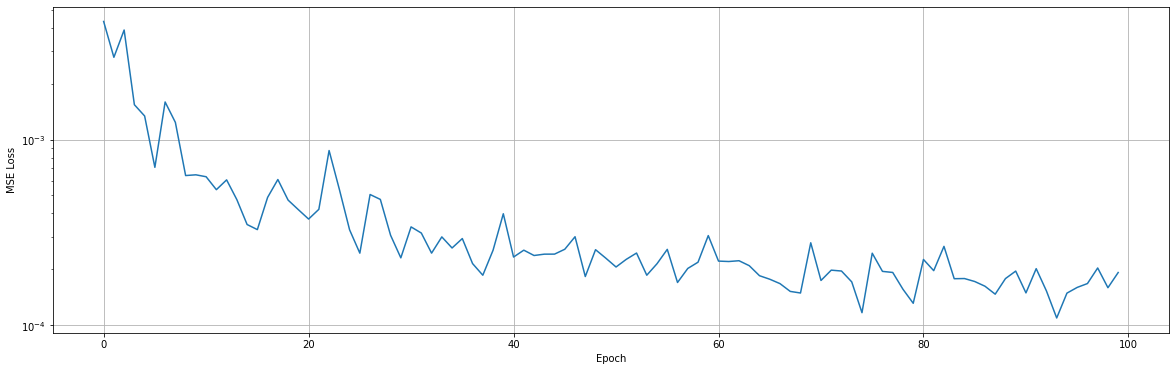

In [68]:
plt.figure(figsize=(20,6))
plt.plot(loss_epoch)
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()

In [6]:
torch.save(model.state_dict(), './sim_autoencoder5.pth')

NameError: name 'model' is not defined

In [9]:
model_state = torch.load("sim_autoencoder5.pth")
model = autoencoder(latent_dim,num_specs)
model.load_state_dict(model_state)

<All keys matched successfully>

## Loss  curves for N runs

In [184]:

#transform = transforms.Compose([torch.from_numpy,torch.clamp(min=1e-20,max=1),torch.log10])
criterion = log_mse_loss

# number of runs
n_runs = 50
num_epochs = 150
# array to contain losses for ach run of 100 epch
iter_losses = []


start_time = time.time()
for run in range(n_runs):
    model = autoencoder(latent_dim,num_specs)
    print("Run: ",run+1)
    loss_epoch = np.zeros([num_epochs])

    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate)#, weight_decay=1e-3)

    for epoch in range(num_epochs):
        permutation = torch.randperm(X.size()[0])
        for i in range(0,X.size()[0], batch_size):
            optimizer.zero_grad()

            indices = permutation[i:i+batch_size]
            batch_x= X[indices]

            outputs = model.forward(batch_x.float())
            loss = criterion(outputs,batch_x)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if(epoch%10 == 0 ):
            print('epoch [{}/{}], loss:{:.6f}'.format(epoch, num_epochs, loss.data.item()))
        loss_epoch[epoch] = loss.data.item()
    
    iter_losses.append(loss_epoch)
print("--- %s seconds ---" % (time.time() - start_time))

#torch.save(model.state_dict(), './sim_autoencoder.pth')


Run:  1
epoch [0/150], loss:0.006443
epoch [10/150], loss:0.001075
epoch [20/150], loss:0.000639
epoch [30/150], loss:0.000414
epoch [40/150], loss:0.000127
epoch [50/150], loss:0.000078
epoch [60/150], loss:0.000099
epoch [70/150], loss:0.000272
epoch [80/150], loss:0.000143
epoch [90/150], loss:0.000081
epoch [100/150], loss:0.000096
epoch [110/150], loss:0.000066
epoch [120/150], loss:0.000046
epoch [130/150], loss:0.000150
epoch [140/150], loss:0.000096
Run:  2
epoch [0/150], loss:0.014357
epoch [10/150], loss:0.003351
epoch [20/150], loss:0.000470
epoch [30/150], loss:0.000258
epoch [40/150], loss:0.000351
epoch [50/150], loss:0.000127
epoch [60/150], loss:0.000055
epoch [70/150], loss:0.000147
epoch [80/150], loss:0.000101
epoch [90/150], loss:0.000305
epoch [100/150], loss:0.000228
epoch [110/150], loss:0.000131
epoch [120/150], loss:0.000215
epoch [130/150], loss:0.000055
epoch [140/150], loss:0.000188
Run:  3
epoch [0/150], loss:0.005532
epoch [10/150], loss:0.001598
epoch [20

epoch [110/150], loss:0.000231
epoch [120/150], loss:0.000210
epoch [130/150], loss:0.000191
epoch [140/150], loss:0.000129
Run:  19
epoch [0/150], loss:0.009158
epoch [10/150], loss:0.001054
epoch [20/150], loss:0.001823
epoch [30/150], loss:0.001499
epoch [40/150], loss:0.000407
epoch [50/150], loss:0.000847
epoch [60/150], loss:0.000314
epoch [70/150], loss:0.000394
epoch [80/150], loss:0.000149
epoch [90/150], loss:0.000462
epoch [100/150], loss:0.000177
epoch [110/150], loss:0.000127
epoch [120/150], loss:0.000462
epoch [130/150], loss:0.000152
epoch [140/150], loss:0.000070
Run:  20
epoch [0/150], loss:0.010185
epoch [10/150], loss:0.000375
epoch [20/150], loss:0.000107
epoch [30/150], loss:0.000142
epoch [40/150], loss:0.000070
epoch [50/150], loss:0.000064
epoch [60/150], loss:0.000169
epoch [70/150], loss:0.000117
epoch [80/150], loss:0.000054
epoch [90/150], loss:0.000047
epoch [100/150], loss:0.000252
epoch [110/150], loss:0.000053
epoch [120/150], loss:0.000321
epoch [130/1

epoch [70/150], loss:0.000110
epoch [80/150], loss:0.000321
epoch [90/150], loss:0.000078
epoch [100/150], loss:0.000215
epoch [110/150], loss:0.000202
epoch [120/150], loss:0.000085
epoch [130/150], loss:0.000198
epoch [140/150], loss:0.000068
Run:  37
epoch [0/150], loss:0.004926
epoch [10/150], loss:0.001899
epoch [20/150], loss:0.000820
epoch [30/150], loss:0.001114
epoch [40/150], loss:0.001145
epoch [50/150], loss:0.000231
epoch [60/150], loss:0.000269
epoch [70/150], loss:0.000143
epoch [80/150], loss:0.000095
epoch [90/150], loss:0.000225
epoch [100/150], loss:0.000169
epoch [110/150], loss:0.000054
epoch [120/150], loss:0.000120
epoch [130/150], loss:0.000238
epoch [140/150], loss:0.000092
Run:  38
epoch [0/150], loss:0.012082
epoch [10/150], loss:0.001208
epoch [20/150], loss:0.001490
epoch [30/150], loss:0.000260
epoch [40/150], loss:0.000196
epoch [50/150], loss:0.000115
epoch [60/150], loss:0.000220
epoch [70/150], loss:0.000064
epoch [80/150], loss:0.000074
epoch [90/150]

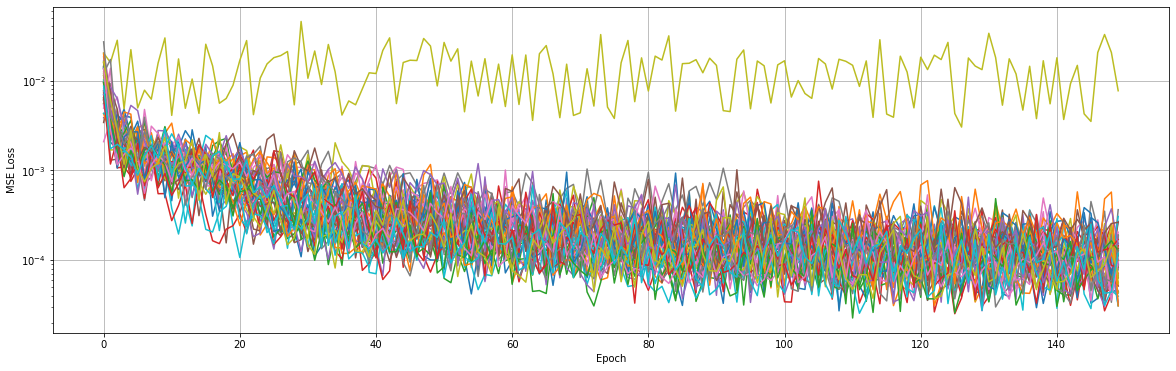

In [185]:
plt.figure(figsize=(20,6))
for i in range(len(iter_losses)):
    plt.plot(iter_losses[i])
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid()

# Test loss statistics

In [12]:


losses = []
for i in range(len(dataset["x_test"])):

    xvec = dataset["x_test"][i]

    xvec_log = normalize_input(xvec,CLIPPING[0],CLIPPING[1])
    # ===================forward=====================
    output = model(xvec_log.float())
    loss = RMSE(output, xvec_log.float())
    losses.append(loss)


Text(0.5, 0, 'Log(Loss)')

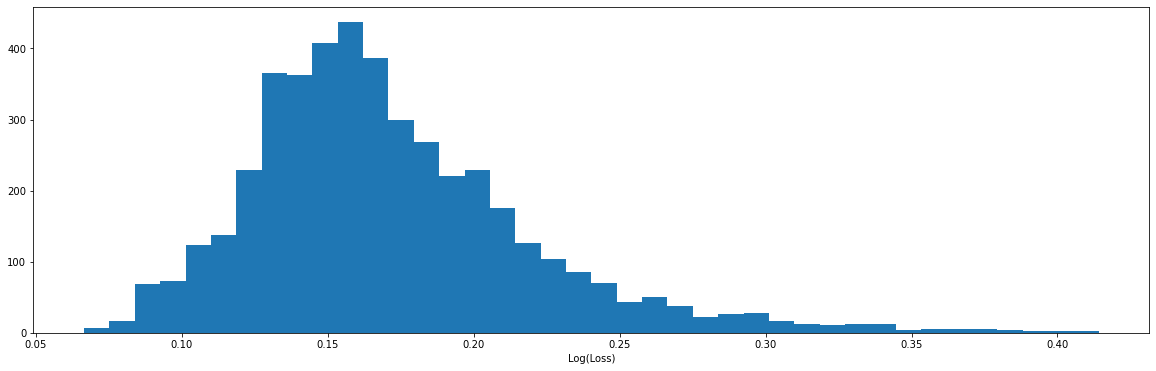

In [14]:
plt.figure(figsize=(20,6))
_=plt.hist(losses,bins=40)
plt.xlabel("Log(Loss)")

#plt.xscale("log")

In [44]:
 losses_report = generate_loss_report(model,dataset["x_test"],dataset["x_test"])

Generating loss report: 94.78 % 
Generating loss report: 99.98 % 

In [42]:
losses_report= losses_report.sort_values(by="mean_err")
losses_report
#losses_report[losses_report["specie"]=="h"]

,specie,mean_err,max_err,min_err,std_err
89,h3o+,0.060658,0.389286,0.000079,0.065493
106,nh4+,0.067040,0.353178,0.000813,0.065105
71,c2h4+,0.070454,0.229706,0.000319,0.056020
68,c2h+,0.070539,0.257879,0.000183,0.057821
130,hso2+,0.071428,0.476939,0.001707,0.084092
...,...,...,...,...,...
75,c-c3h2+,0.179535,1.255219,0.005563,0.214977
33,h3co,0.189176,0.692837,0.000889,0.163573
10,c2h2,0.196200,0.846324,0.000952,0.164661
88,h2o+,0.196921,1.620052,0.001846,0.230260


Text(0, 0.5, 'Max RMSE')

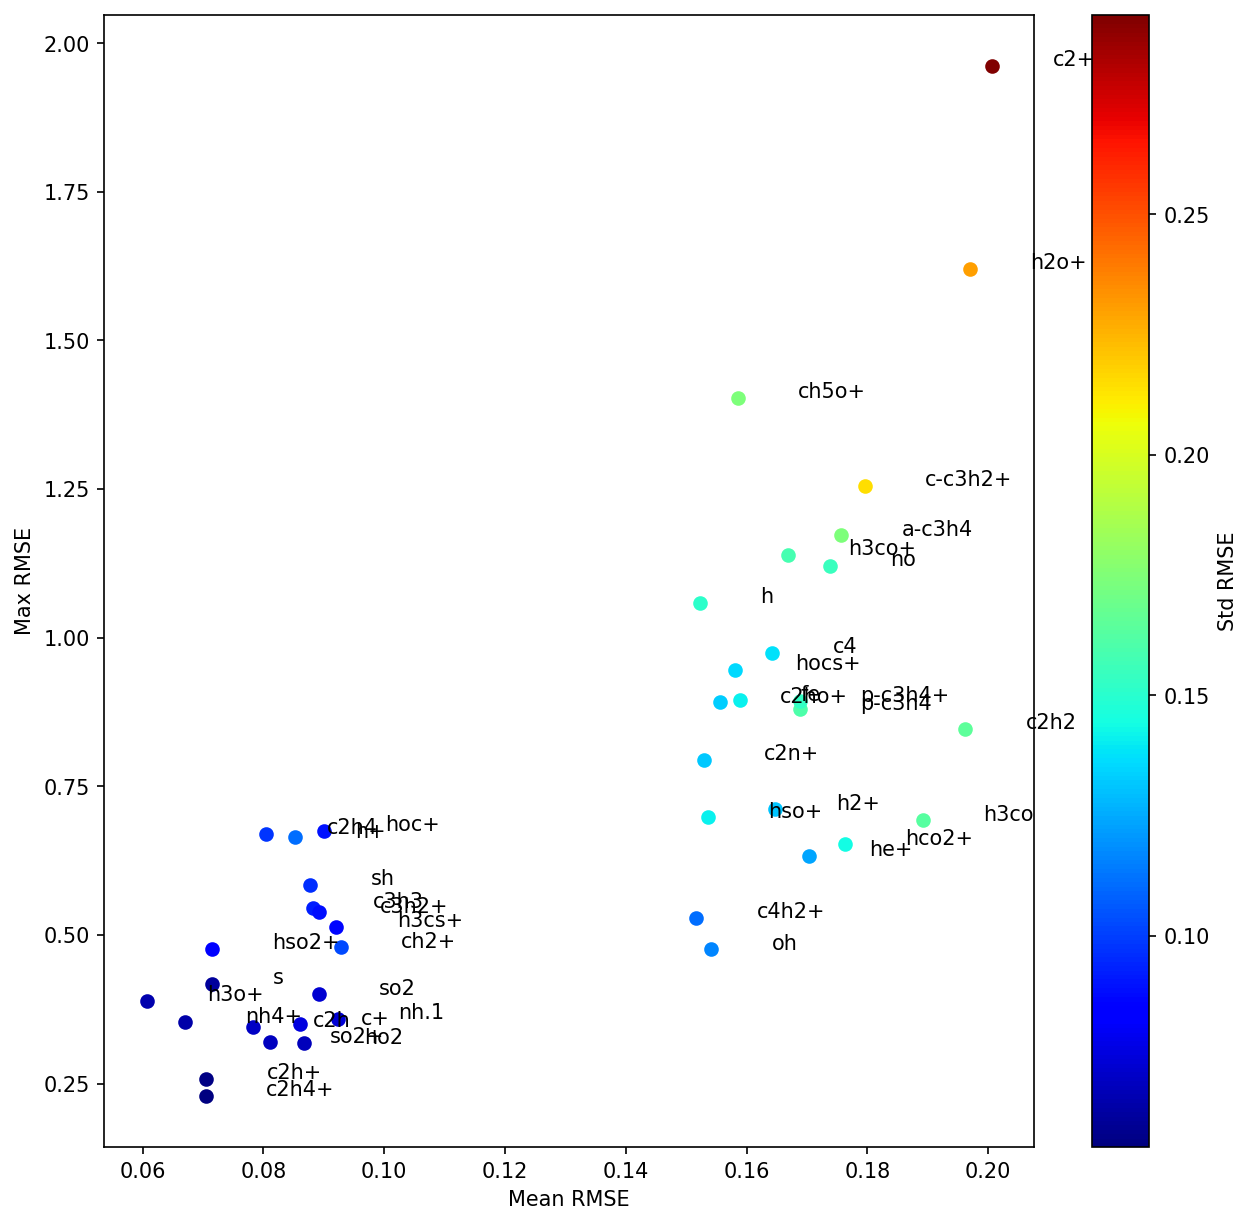

In [28]:
z_filter = 1
z_outliers = get_z_outliers(losses_report,["mean_err"],z_filter,"mean_err")

plt.figure(figsize=(10,10),dpi=150)
for idx,row in z_outliers.iterrows():
    plt.scatter(row["mean_err"],row["max_err"],label=row["specie"],
                c=row["std_err"],cmap="jet",vmax=np.max(z_outliers["std_err"]),vmin=np.min(z_outliers["std_err"]))
  
    plt.text(x=row["mean_err"]+0.01,y=row["max_err"],s=row["specie"],fontsize=10)
    #plt.text(x=row["mean_err"]+0.01,y=row["max_err"]-0.02,s=round(row["std_err"],2),fontsize=8)
plt.colorbar(label="Std RMSE")
plt.xlabel("Mean RMSE")
plt.ylabel("Max RMSE")

In [29]:
n_headtail =4 
best_worst = list(z_outliers["specie"].values[:n_headtail])+list(z_outliers["specie"].values[-n_headtail:])

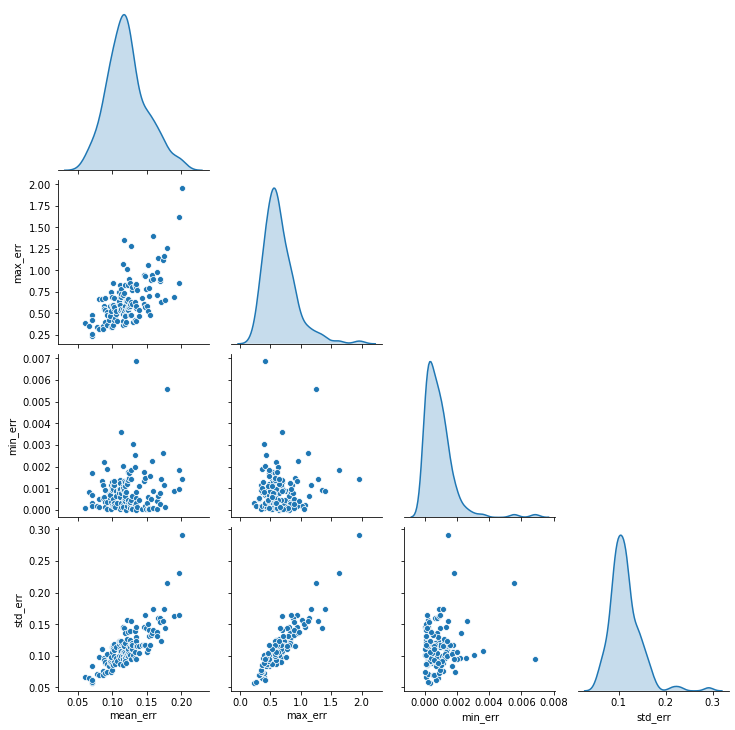

In [30]:
import seaborn as sns

sns.pairplot(data=losses_report,diag_kind="kde",corner=True)

In [49]:
chosen_sc = "sc_2"
chosen_abs = ["h","h2","c","o","c+","co"]+best_worst
chosen_abs =  list(dict.fromkeys(chosen_abs)) #remove duplicates if any
cols_abs = dataset_allc["cols"]
curves_to_plot = []
latent_to_plot= []

data_ab = dataset_allc[chosen_sc]["x"]
data_t = dataset_allc[chosen_sc]["t"]
data_pred = []
data_latent = []

loss_rep_ = generate_loss_report(model,data_ab,data_ab)

for i in range(len(data_ab)):
    vec = data_ab[i]
    xvec_log = normalize_input(vec,CLIPPING[0],CLIPPING[1])
    output = model(xvec_log.float()) 
    ab_rec_i = reconstruct_output(output,CLIPPING[0],CLIPPING[1])
    data_pred.append(ab_rec_i)
    
    latent_rep  = model.encoder(xvec_log.float()).detach().numpy()
    data_latent.append(latent_rep)
    s = "Evaluating  curves: {0} % ".format(round(100*i/len(data_ab),2))
    if i == len(data_ab)-1:
        s+='\n'        
    if i>0: 
        s = '\r'+s
    print(s, end='')

print("Chosing species...")
for sp in chosen_abs:
    #index of species
    ii = [i for  i in range(len(cols_abs)) if cols_abs[i]==sp][0]
    ab_i = np.array(dataset_allc[chosen_sc]["x"])[:,ii]
    rec_i = np.array(data_pred)[:,ii]
    curves_to_plot.append([sp,ab_i,rec_i])
print("Done") 
    

Generating loss report: 99.98 % 
Evaluating  curves: 99.98 % 
Chosing species...
Done


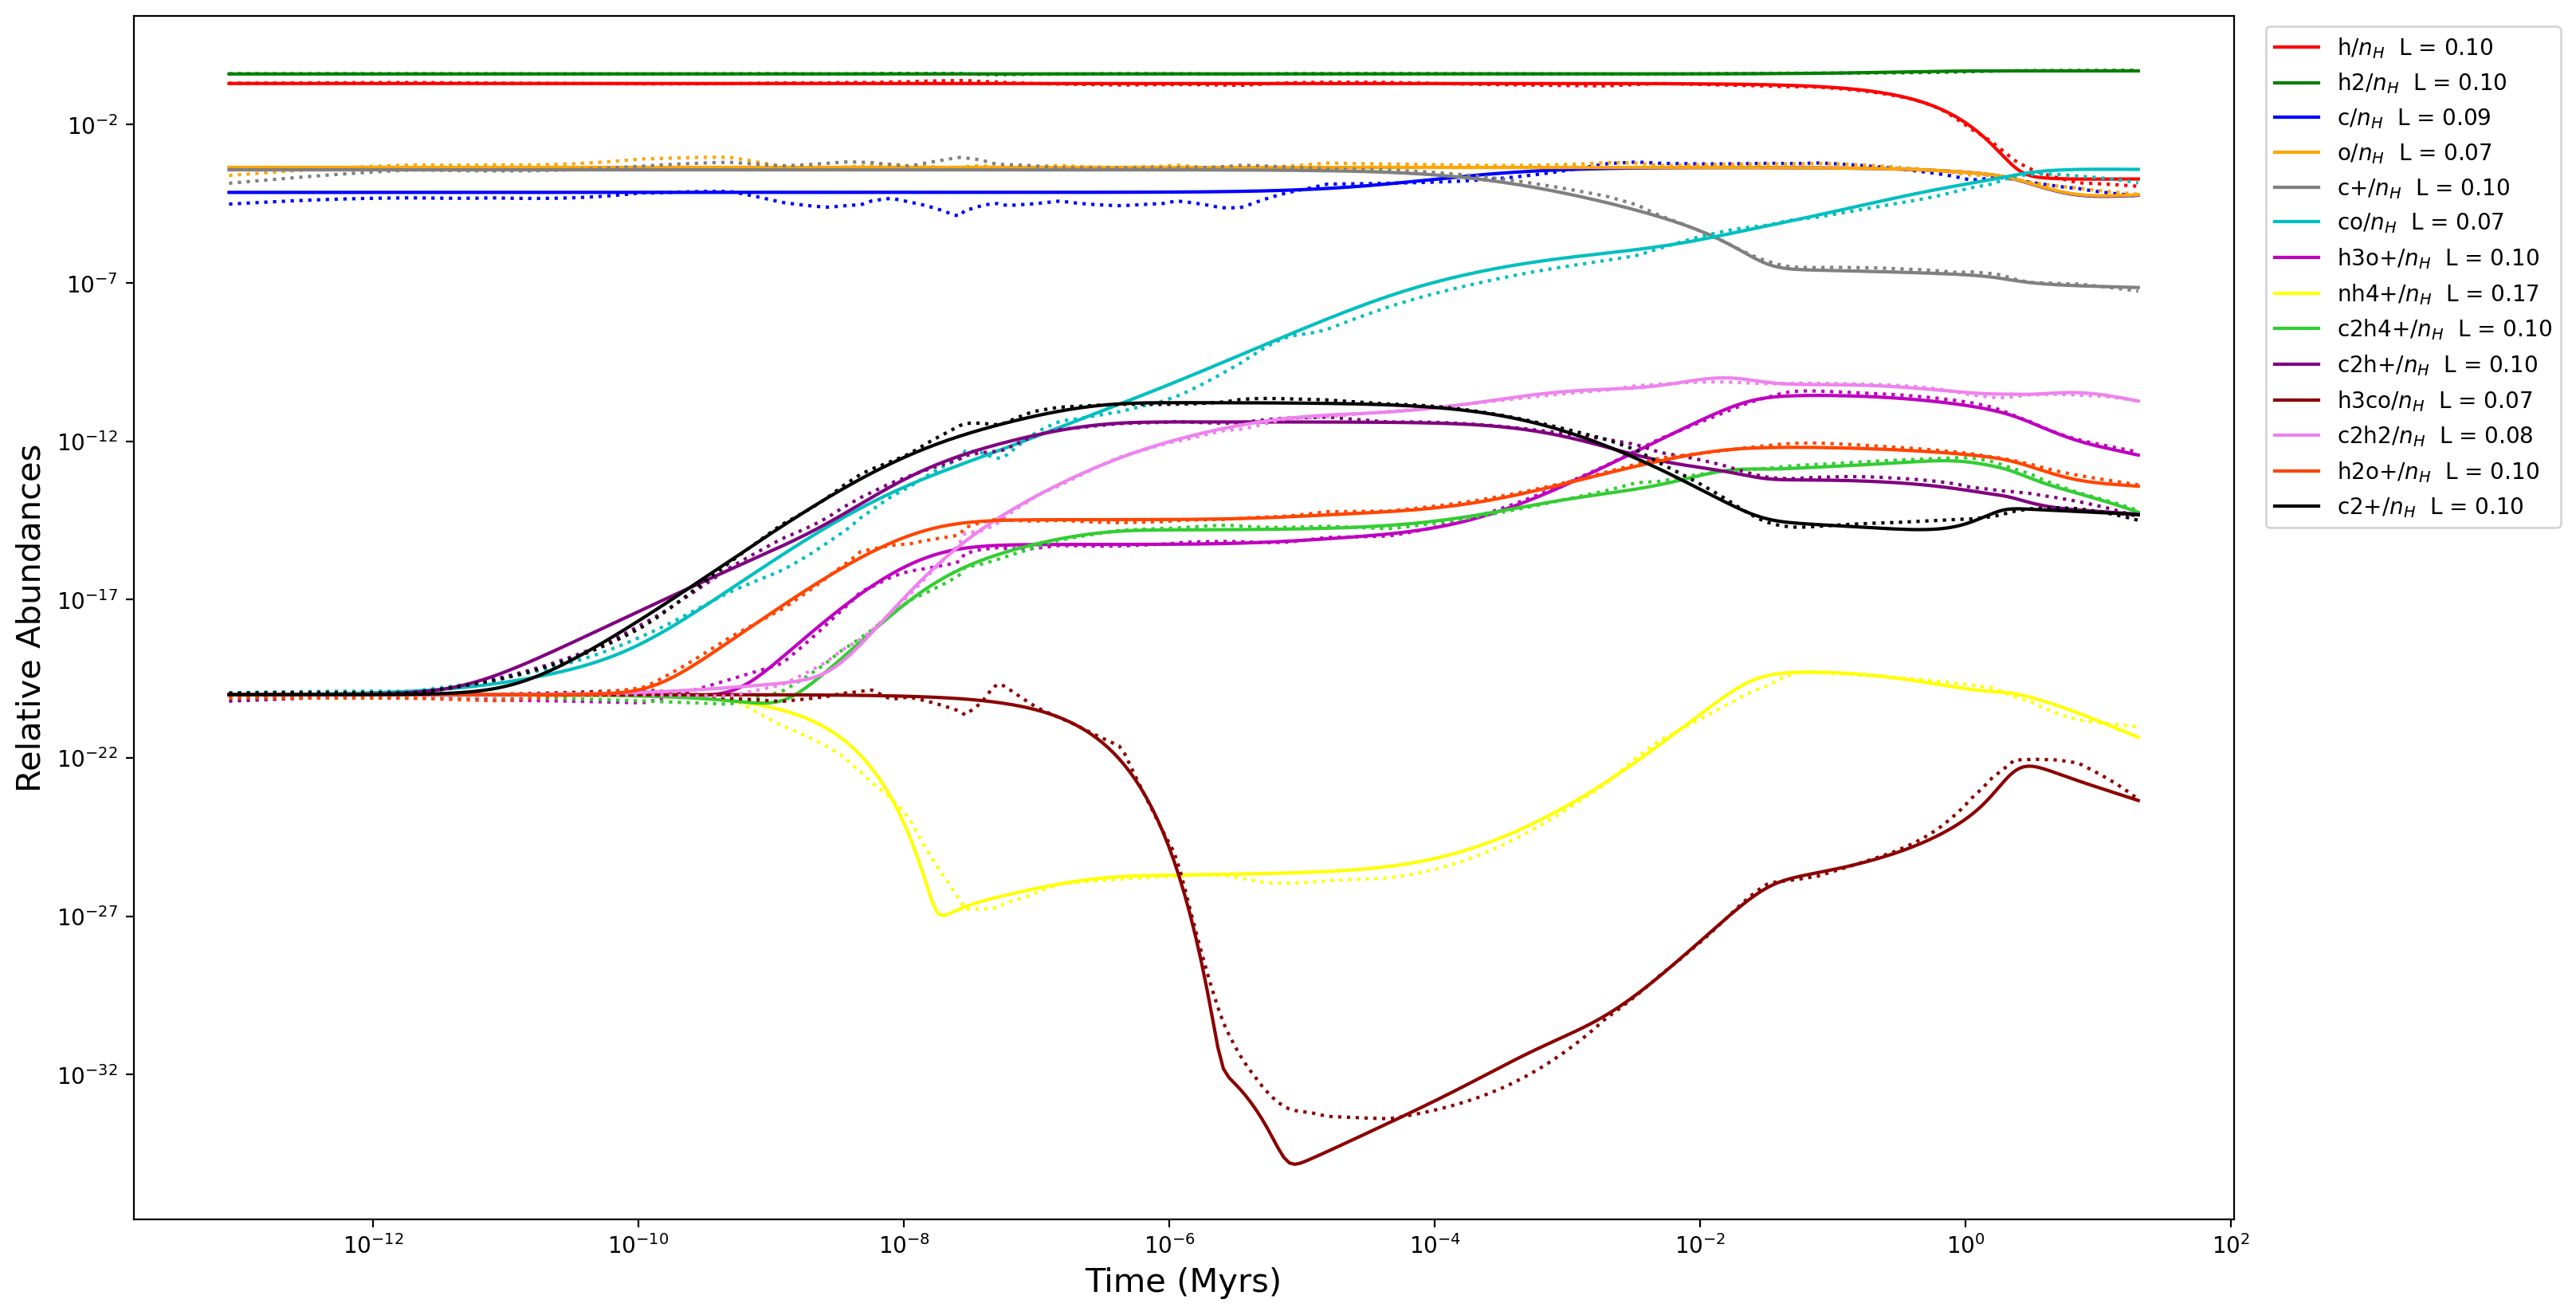

In [51]:
plt.figure(figsize=(17,10),dpi=200)
colors = ["r","g","b","orange","grey","c","m","yellow","limegreen","purple","darkred","violet","orangered","k"]
#for t in dataset["times"]:
    #plt.axvline(t,c="grey",linestyle=":")
for i in range(len(curves_to_plot)):
    elem = curves_to_plot[i]
    meanerr = loss_rep_[loss_rep_["specie"]==elem[0]]["mean_err"].values[0]
    txt = elem[0]+"/$n_H$  L = {:.2f}".format(meanerr)
    #plot abundances
    plt.plot(data_t,elem[1],label=txt,c=colors[i],linestyle="-")
    # plot reconstruced abundances
    plt.plot(data_t,elem[2],c=colors[i],linestyle=":")
    

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Time (Myrs)",fontsize=15)
plt.ylabel("Relative Abundances",fontsize=15)
plt.legend(bbox_to_anchor=(1.01, 1))


In [ ]:

plt.figure(figsize=(15,6))
lat_= np.array(data_latent).T
for i in range(len(lat_)):
    plt.plot(data_t,lat_[i],label = "$Z_{}$".format(i+1))
plt.xscale("log")
plt.xlabel("Time (Myrs)",fontsize=15)
plt.ylabel("Latent output activation",fontsize=15)
plt.legend()

In [32]:
model.encoder(xvec_log.float()).detach().numpy()

array([ 0.2062965 , -0.15048179,  0.34964588,  0.55880916, -0.4806748 ],
      dtype=float32)

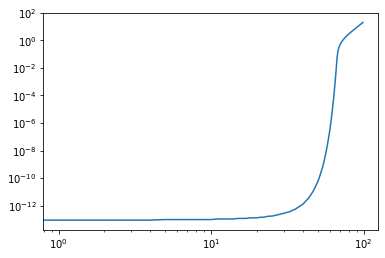

In [44]:
plt.loglog(dataset["times"])

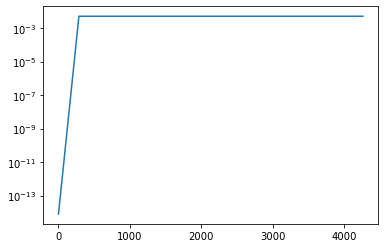

In [33]:
plt.plot(data_t[1:]-data_t[:-1])
plt.yscale("log")

In [67]:
np.log10(26000)

4.414973347970818